In [18]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import json

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import time
import torch.nn.functional as F
import torch.nn as nn
import torch
import albumentations.pytorch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils
from tqdm.notebook import trange, tqdm


In [19]:
# helper function for data visualization
from skimage import color

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [20]:

class SkinDataset(Dataset):
    def __init__(self, df_file, augmentation=None, preprocessing=None, root='./'):
        super().__init__()
        self.data = pd.read_csv(df_file)
        #self.data = json.load(open('data/training_clean_dataset.json'))
        self.label_names = ['B']+list(self.data['lesions'].unique())
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.root = root
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root, self.data.loc[idx,'image_full_path']))
        mask = self.get_mask_pil_image(idx, image)
        
        image = np.array(image)
        assert image.dtype == np.uint8
        # extract certain classes from mask
        # masks = [(mask == v) for v in range(len(self.label_names))]
        # mask = np.stack(masks, axis=-1).astype('float')
         # apply augmentations
    
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.data.index)
    
    def get_mask_pil_image(self, idx, image):
        item = json.loads(self.data.loc[idx,'annotations'].replace("\'", "\""))
        polygons = []
        for ann in item:
            if "polygon" in ann:
                loc = ann['polygon']['location'][0]
                points = []
                for point_num in range(1, len(loc.keys())//2+1):
                    points.append([loc[f'x{point_num}'], loc[f'y{point_num}']])
                polygons.append(np.array(points))
        mask = np.zeros((image.size[1], image.size[0]))
        cv2.fillPoly(mask, polygons, self.label_names.index(self.data.loc[idx, 'lesions']))
        mask = mask.astype(np.uint8)
        
        return mask

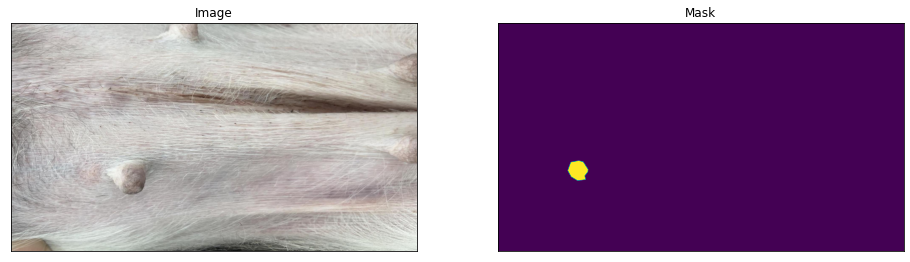

In [21]:
dataset = SkinDataset('../data/training_clean_dataset.csv', root='/mnt/f/skin/Classification-skin-disease-pets')

image, mask = dataset[500]
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [22]:

import albumentations as albu
def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#         albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.Resize(288, 512),

        albu.GaussNoise(p=0.2),
        #albu.Perspective (p=0.5),

        # albu.OneOf(
        #     [
        #         albu.CLAHE(p=1),
        #         albu.RandomBrightnessContrast(p=1),
        #         albu.RandomGamma(p=1),
        #     ],
        #     p=0.9,
        # ),

        albu.OneOf(
            [
                albu.Sharpen (p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
                albu.RandomBrightnessContrast(p=1),
            ],
            p=0.9,
        ),

        # albu.OneOf(
        #     [
        #         
        #         albu.HueSaturationValue(p=1),
        #     ],
        #     p=0.9,
        # ),
        albu.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        albumentations.pytorch.ToTensorV2()
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

#preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [23]:
augmented_dataset = SkinDataset('../data/training_clean_dataset.csv',
    augmentation=get_training_augmentation(), root='/mnt/f/skin/Classification-skin-disease-pets'
)

## Create model and train

In [24]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = dataset.label_names
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
model.to(DEVICE)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [29]:
train_num = int(len(augmented_dataset)*0.8)
val_num = len(augmented_dataset) - train_num
train_dataset, val_dataset = torch.utils.data.random_split(augmented_dataset, [train_num, val_num], generator=torch.Generator().manual_seed(42))
small_train_dataset = torch.utils.data.Subset(train_dataset, range(1000))
small_val_dataset = torch.utils.data.Subset(val_dataset, range(100))

train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(small_val_dataset, batch_size=16, shuffle=False, num_workers=0)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

In [30]:
for epoch in range(2):  # loop over the dataset multiple times
    losses = []
    running_loss = 0.0

    for i, data in enumerate(tqdm(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #pickle_data.append((inputs, labels))
        inputs, labels = inputs.to(DEVICE), labels.long().to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        if i == 30:
            break
        # print statistics
        losses.append(loss.item())
    print(np.mean(losses))
print('Finished Training')

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 30/32 [00:53<00:03,  1.78s/it]


0.15218417694171268


  6%|██████████████▏                                                                                                                                                                                                                   | 2/32 [00:04<01:07,  2.24s/it]


KeyboardInterrupt: 